In [3]:
%reload_ext autoreload
%autoreload 2

from u_cmab import Fourier
from u_cmab import Static_UM
from u_cmab import plot_results
from u_cmab import LinUCB, offlineEvaluate
import simulation_code

import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt

# Parameters
- `window`: size of the windowed average uplift regret
- `static_dataset_size`: amount of random experiments conducted and provided to the static uplift model
- `total_experiment_count`: length of the total run
- `run_count`: total amount of simulations created, take note before increasing as this will increase runtime significantly

In [4]:
window = 150
static_dataset_size = 5000
total_experiment_count = 10000
run_count = 10# ** 2

def map_context(con, arm, f):
    return f.basis(con, arm)

In [5]:
fourier_ids = np.empty([run_count,total_experiment_count])
fourier_reg_ids = np.empty([run_count, total_experiment_count])
linucb_ids = np.empty([run_count, total_experiment_count])
linucb_reg_ids = np.empty([run_count, total_experiment_count])
static_ids = np.empty([run_count, total_experiment_count])
static_params = np.empty([run_count, 2])

for i in range(run_count):    
    ply_q = np.random.randint(6,10)
    tau = (.45 - .25) * np.random.ranf() + .25
        #  the order of the Fourier approx. (O) is best chosen in 
        #  function of D as O and D affect the amount of frequency 
        #  vectors exponentially, causing a curse of dimensionality
        #  [Konindaris et al., 2011].
    D = np.random.randint(2,4)   
    O = 7-D 
            

    K=np.random.normal(1,.5, ply_q+1)
    sim = simulation_code.Simulation(
        D=D, base_functions=np.array([
            simulation_code.Sine_Base(f=np.random.randint(6,10)), 
            simulation_code.Sine_Base(f=np.random.randint(4,7))
        ]))
    
    fourier = Fourier(sim, order=O)
    fourier_id, fourier_dm, fourier_reg_id, tot_rew, exec_ac, tot_rew_reg, exec_ac_reg = fourier.run(
        epsilon=.07, 
        alpha=(O-1)/1000,
        tau=tau, window=window, 
        lifetime=total_experiment_count)
    print("--e-greedy {} Completed--".format(i+1))
    
    Data = fourier.RP_run_history.values
    
    cntxt_0 = np.array([map_context(c, 0, fourier) for c in Data[:,:D]])
    cntxt_1 = np.array([map_context(c, 1, fourier) for c in Data[:,:D]])

    contexts = np.append(cntxt_0, cntxt_1, axis=1)
    
    print("--Contexts {} Created--".format(i+1))
    
    linucb = LinUCB(2, len(cntxt_0[0]), 1.0)
    results_LinUCB, chosen_arms_LinUCB, cumulative_reward_LinUCB = offlineEvaluate(
        linucb, 
        np.array([Data[:,-2], Data[:,-3]]).T, 
        contexts, tau, nrounds=total_experiment_count, u_cmab=1)
    
    linucb_diff = np.array([])
    linucb_id = np.array([])

    for j in range(len(chosen_arms_LinUCB)):
        linucb_diff = np.append(linucb_diff, abs(chosen_arms_LinUCB[j] - Data[:,-1][j]))
        linucb_id = np.append(linucb_id, np.average(linucb_diff[-window:]))
    print("--LinUCB U-CMAB {} Completed--".format(i+1))
    
    linucb_reg = LinUCB(2, len(cntxt_0[0]), 1.0)
    results_LinUCB_reg, chosen_arms_LinUCB_reg, cumulative_reward_LinUCB_reg = offlineEvaluate(
        linucb_reg, 
        np.array([Data[:,-2], Data[:,-3]]).T, 
        contexts, tau, nrounds=total_experiment_count, u_cmab=0)
    
    linucb_reg_diff = np.array([])
    linucb_reg_id = np.array([])

    for j in range(len(chosen_arms_LinUCB_reg)):
        linucb_reg_diff = np.append(linucb_reg_diff, abs(chosen_arms_LinUCB_reg[j] - Data[:,-1][j]))
        linucb_reg_id = np.append(linucb_reg_id, np.average(linucb_reg_diff[-window:]))
    print("--LinUCB CMAB {} Completed--".format(i+1))

    static = Static_UM(RP_run_history=fourier.RP_run_history)
    up, static_id = static.run(
        static_dataset_size=static_dataset_size, 
        total_experiment_count=total_experiment_count, 
        tau=tau, window=window)
    
    fourier_ids[i] = fourier_id
    fourier_reg_ids[i] = fourier_reg_id
    static_ids[i] = static_id
    linucb_ids[i] = linucb_id
    linucb_reg_ids[i] = linucb_reg_id
    static_params[i] = list(up.rand_search_.best_params_.values())

--e-greedy 1 Completed--
--Contexts 1 Created--
--LinUCB U-CMAB 1 Completed--
--LinUCB CMAB 1 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   13.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   15.9s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5000 AND len(decisions_after_r...) = 5000
10001
--e-greedy 2 Completed--
--Contexts 2 Created--
--LinUCB U-CMAB 2 Completed--
--LinUCB CMAB 2 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    7.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.4s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5000 AND len(decisions_after_r...) = 5000
10001
--e-greedy 3 Completed--
--Contexts 3 Created--
--LinUCB U-CMAB 3 Completed--
--LinUCB CMAB 3 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    6.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.1s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5000 AND len(decisions_after_r...) = 5000
10001
--e-greedy 4 Completed--
--Contexts 4 Created--
--LinUCB U-CMAB 4 Completed--
--LinUCB CMAB 4 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    6.7s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5000 AND len(decisions_after_r...) = 5000
10001
--e-greedy 5 Completed--
--Contexts 5 Created--
--LinUCB U-CMAB 5 Completed--
--LinUCB CMAB 5 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 131 out of 150 | elapsed:    6.5s remaining:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    7.3s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5000 AND len(decisions_after_r...) = 5000
10001
--e-greedy 6 Completed--
--Contexts 6 Created--
--LinUCB U-CMAB 6 Completed--
--LinUCB CMAB 6 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    7.8s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5000 AND len(decisions_after_r...) = 5000
10001
--e-greedy 7 Completed--
--Contexts 7 Created--
--LinUCB U-CMAB 7 Completed--
--LinUCB CMAB 7 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    8.7s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5000 AND len(decisions_after_r...) = 5000
10001
--e-greedy 8 Completed--
--Contexts 8 Created--
--LinUCB U-CMAB 8 Completed--
--LinUCB CMAB 8 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    7.4s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.5s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5000 AND len(decisions_after_r...) = 5000
10001
--e-greedy 9 Completed--
--Contexts 9 Created--
--LinUCB U-CMAB 9 Completed--
--LinUCB CMAB 9 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    8.2s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5000 AND len(decisions_after_r...) = 5000
10001
--e-greedy 10 Completed--
--Contexts 10 Created--
--LinUCB U-CMAB 10 Completed--
--LinUCB CMAB 10 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    8.8s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5000 AND len(decisions_after_r...) = 5000
10001


In [6]:
avg_ids = [np.mean(static_ids, axis=0),np.mean(fourier_ids, axis=0),  np.mean(fourier_reg_ids, axis=0), np.mean(linucb_ids, axis=0), np.mean(linucb_reg_ids, axis=0)]
stds = [np.std(static_ids, axis=0),np.std(fourier_ids, axis=0),  np.std(fourier_reg_ids, axis=0), np.std(linucb_ids, axis=0), np.std(linucb_reg_ids, axis=0)]

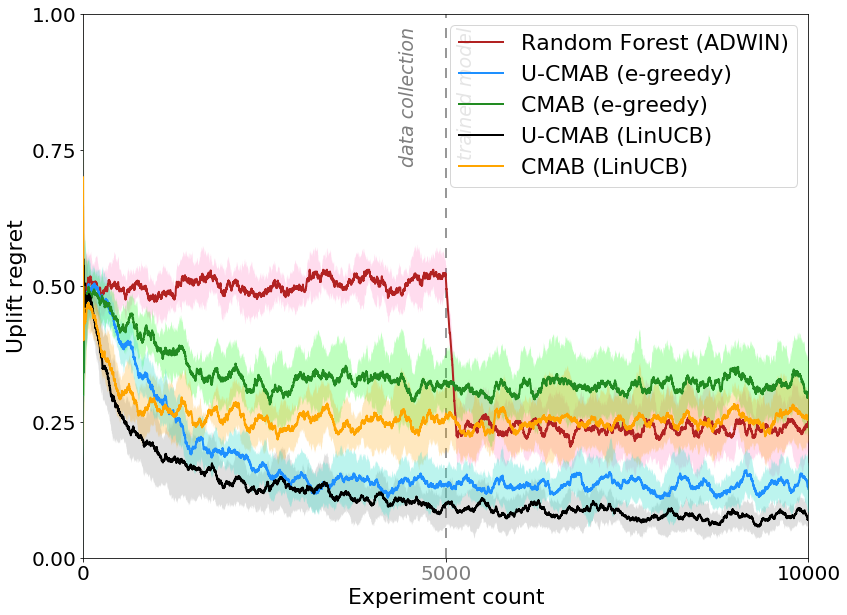

In [7]:
line_args=[
    {"color": "firebrick", "linewidth": 2, "zorder": 102, "label": "Random Forest (ADWIN)"},
    {"color": "dodgerblue", "linewidth": 2, "zorder": 103, "label": "U-CMAB (e-greedy)"},      
    {"color": "forestgreen", "linewidth": 2, "zorder": 103, "label": "CMAB (e-greedy)"},
    {"color": "black", "linewidth": 2, "zorder": 103, "label": "U-CMAB (LinUCB)"}, 
    {"color": "orange", "linewidth": 2, "zorder": 103, "label": "CMAB (LinUCB)"}]
band_args=[
    {"color": "deeppink", "alpha": .15, "linewidth":0, "zorder": 100},
    {"color": "turquoise", "alpha": .35, "linewidth":0, "zorder": 101},  
    {"color": "lime", "alpha": .25, "linewidth":0, "zorder": 100}, 
    {"color": "gray", "alpha": .25, "linewidth":0, "zorder": 100}, 
    {"color": "orange", "alpha": .25, "linewidth":0, "zorder": 100}]
all_lines_args=[
    {"color": "crimson", "alpha": .1, "linewidth": .5},
    {"color": "deepskyblue", "alpha": .1, "linewidth": .5},  
    {"color": "black", "alpha": .1, "linewidth": .5}]
std_args=[
    {"color": "crimson", "linestyle": "--", "linewidth": 2, "dashes": [10, 10]},
    {"color": "deepskyblue", "linestyle": "--", "linewidth": 2, "dashes": [10, 10]},      
    {"color": "black", "linestyle": "--", "linewidth": 2, "dashes": [10, 10]},
    {"color": "gray", "linestyle": "--", "linewidth": 2, "dashes": [10, 10]},
    {"color": "orange", "linestyle": "--", "linewidth": 2, "dashes": [10, 10]}]

stop_RP_args={"color": "tab:gray", "linewidth":2, "linestyle": "--", "dashes": [5,5], "alpha": .8}
stop_RP_text_args={"y": .95, "color": "tab:gray", "size": 19, "fontstyle": "italic"}
drift_line_args={"linestyle": ":", "color": "tab:green", "alpha": 1, "linewidth": 3}

fig, ax = plot_results(avg_ids, stds, np.array([]), 
                 line_args=line_args, band_args=band_args, all_lines_args=all_lines_args, std_args=std_args,
                stop_RP=static_dataset_size, stop_RP_args=stop_RP_args, stop_RP_text_args=stop_RP_text_args)

In [8]:
ax.figure.savefig('regular_regret_2.pdf', bbox_inches='tight', pad_inches=0)